## Checking Dataset

In [ ]:
import torch
import torchvision
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import collections

In [ ]:
print(torchvision.__version__)

0.21.0+cu124


In [ ]:
# We’ll apply a simple transform (resize to 224, convert to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = OxfordIIITPet(
    root="./oxford_iiit_pet_data",   # Directory to download/store the dataset
    download=True,
    transform=transform,
    target_types="category"
)

100%|██████████| 792M/792M [00:18<00:00, 41.8MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 16.3MB/s]


In [ ]:
# Just trainval (~3680 images)
dataset_trainval = OxfordIIITPet(
    root="./oxford_iiit_pet_data",
    download=True,
    target_types="category",
    split="trainval"
)
print("TrainVal split size:", len(dataset_trainval))

# Just test (~3669 images)
dataset_test = OxfordIIITPet(
    root="./oxford_iiit_pet_data",
    download=True,
    target_types="category",
    split="test"
)
print("Test split size:", len(dataset_test))

TrainVal split size: 3680
Test split size: 3669


In [ ]:
num_samples = len(dataset)
classes = dataset._labels  # This is a list of integer labels
num_classes = len(set(classes))

print(f"Number of total images: {num_samples}")
print(f"Number of unique classes: {num_classes}")

Number of total images: 3680
Number of unique classes: 37


In [ ]:
from collections import Counter

class_names = dataset.classes
label_counts = Counter()
for _, label in dataset:
    label_counts[label] += 1

# Or if dataset._labels is accessible:
# label_counts = Counter(dataset._labels)

print("Label distribution (label_index -> count):")
for label_idx, count in sorted(label_counts.items(), key=lambda x: x[0]):
    print(f"  {label_idx:2d}: {class_names[label_idx]} -> {count}")

Label distribution (label_index -> count):
   0: Abyssinian -> 100
   1: American Bulldog -> 100
   2: American Pit Bull Terrier -> 100
   3: Basset Hound -> 100
   4: Beagle -> 100
   5: Bengal -> 100
   6: Birman -> 100
   7: Bombay -> 96
   8: Boxer -> 100
   9: British Shorthair -> 100
  10: Chihuahua -> 100
  11: Egyptian Mau -> 93
  12: English Cocker Spaniel -> 96
  13: English Setter -> 100
  14: German Shorthaired -> 100
  15: Great Pyrenees -> 100
  16: Havanese -> 100
  17: Japanese Chin -> 100
  18: Keeshond -> 100
  19: Leonberger -> 100
  20: Maine Coon -> 100
  21: Miniature Pinscher -> 100
  22: Newfoundland -> 96
  23: Persian -> 100
  24: Pomeranian -> 100
  25: Pug -> 100
  26: Ragdoll -> 100
  27: Russian Blue -> 100
  28: Saint Bernard -> 100
  29: Samoyed -> 100
  30: Scottish Terrier -> 100
  31: Shiba Inu -> 100
  32: Siamese -> 99
  33: Sphynx -> 100
  34: Staffordshire Bull Terrier -> 100
  35: Wheaten Terrier -> 100
  36: Yorkshire Terrier -> 100


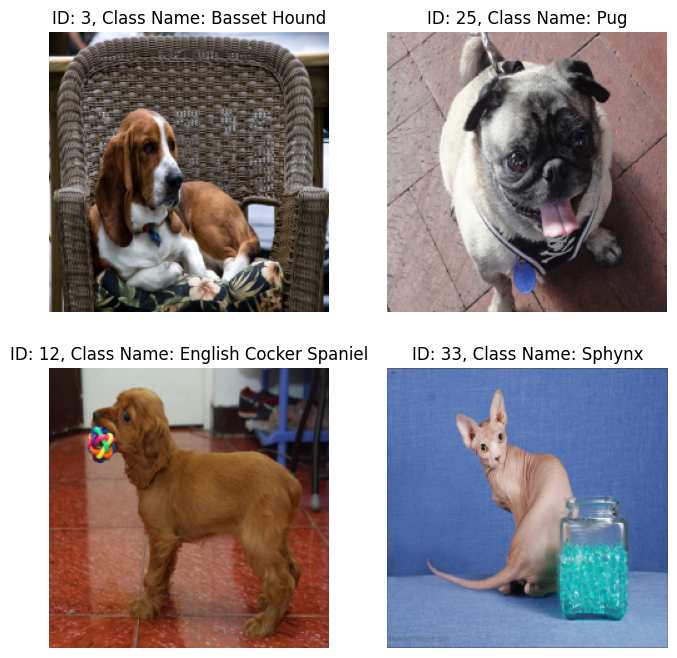

In [ ]:
import random

# Display 4 random samples
plt.figure(figsize=(8, 8))
for i in range(4):
    idx = random.randint(0, num_samples - 1)
    image, label = dataset[idx]
    # Convert from Tensor [C,H,W] -> numpy [H,W,C]
    image_np = image.permute(1, 2, 0).numpy()
    plt.subplot(2, 2, i + 1)
    plt.imshow(image_np)
    plt.title(f"ID: {label}, Class Name: {class_names[label]}")
    plt.axis("off")

plt.show()

# Simple Segmentation Model - Fully Supervised Learning

---
Below is an end-to-end example of training a semantic segmentation model on the Oxford-IIIT Pet dataset using PyTorch and TorchVision. We will:



1.  Download the dataset with segmentation masks.
2.  Preprocess images and masks properly (e.g., resizing, converting to tensors).
3. Use a pretrained segmentation model (fcn_resnet50) and adjust the final layers for our specific number of classes.
4. Write a simple training loop to illustrate how to train on these segmentation masks.

Note:

*   	The Oxford-IIIT Pet “trimaps” are stored with pixel values {1, 2, 3} (three classes: pet, border, background). We will shift them to {0, 1, 2} so that they can be fed into a standard CrossEntropyLoss.

*     This code is minimal and does not include advanced data augmentations or hyperparameter tuning.


# 1. Imports and Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
from torch.utils.data import DataLoader, ConcatDataset, random_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


# 2. Create a Custom Dataset Class for Segmentation

By default, OxfordIIITPet can return only one type of target at a time. If we specify target_types="segmentation", we get the segmentation mask as a PIL image. We need to ensure:



*  Images get resized/normalized appropriately.

*  Masks (trimaps) get resized with nearest-neighbor interpolation (so we don’t blur labels) and converted to LongTensor for use with nn.CrossEntropyLoss.
* Values in the mask are shifted from {1, 2, 3} to {0, 1, 2} so the final layer can predict 3 channels correctly.


We can do this in a small wrapper dataset:

In [3]:
class OxfordPetsSegmentation(torch.utils.data.Dataset):
    def __init__(self, root, split='trainval', transform_image=None, transform_mask=None):
        """
        Args:
            root: Directory for the Oxford-IIIT Pet data.
            split: 'trainval' or 'test' in most TorchVision versions (loads ~3680 or ~3669 images).
            transform_image: torchvision or custom transforms for the input image.
            transform_mask: torchvision or custom transforms for the target mask.
        """
        # Load the base dataset with only segmentation masks
        self.dataset = OxfordIIITPet(
            root=root,
            download=True,
            target_types="segmentation",
            split=split
        )
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __getitem__(self, idx):
        # OxfordIIITPet returns: (PIL Image, PIL Mask)
        image, mask = self.dataset[idx]

        # Apply image transforms if provided
        if self.transform_image is not None:
            image = self.transform_image(image)

        # Apply mask transforms if provided
        if self.transform_mask is not None:
            mask = self.transform_mask(mask)

        # The trimap is typically 1=pet, 2=border, 3=background
        # Shift to 0-based: (0=pet, 1=border, 2=background)
        # If your dataset uses different labeling, adjust here.
        mask = mask - 1

        return image, mask

    def __len__(self):
        return len(self.dataset)

# 3. Define Our Transforms

We’ll:
  * Resize both the image and mask to a smaller resolution (e.g., 224×224) for quick experimentation.
  * Convert the image to a tensor and optionally normalize.
  * Convert the mask to a tensor (long dtype) without interpolation artifacts.

In [4]:
# For the input image: resize, convert to Tensor, (optionally) normalize
transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # You can add normalization if desired (e.g., mean/std from ImageNet)
    # transforms.Normalize([0.485, 0.456, 0.406],
    #                      [0.229, 0.224, 0.225])
])

# For the segmentation mask: resize with nearest neighbor, convert to tensor (long)
transform_mask = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor(),         # Produces a ByteTensor in [1..3]
    transforms.Lambda(lambda x: x.squeeze(0).long()),  # shape [H,W], type Long
])

# Create dataset(s)
dataset_trainval = OxfordPetsSegmentation(
    root="./oxford_iiit_data",
    split="trainval",
    transform_image=transform_image,
    transform_mask=transform_mask,
)
print("TrainVal size:", len(dataset_trainval))

dataset_test = OxfordPetsSegmentation(
    root="./oxford_iiit_data",
    split="test",
    transform_image=transform_image,
    transform_mask=transform_mask,
)
print("Test size:", len(dataset_test))

# Concatenate them if you want the full ~7,349 images:
# from torch.utils.data import ConcatDataset
# dataset_full = ConcatDataset([dataset_trainval, dataset_test])
# print("Full dataset size:", len(dataset_full))

100%|██████████| 792M/792M [00:08<00:00, 91.8MB/s]
100%|██████████| 19.2M/19.2M [00:00<00:00, 40.3MB/s]


TrainVal size: 3680
Test size: 3669


We’ll just keep trainval and do our own split into training and validation subsets:

In [5]:
train_size = int(0.8 * len(dataset_trainval))
val_size = len(dataset_trainval) - train_size
train_ds, val_ds = random_split(dataset_trainval, [train_size, val_size])

print(f"Split trainval into: train={len(train_ds)}, val={len(val_ds)}")

Split trainval into: train=2944, val=736


# 4. Create Dataloaders

In [6]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)  # change batchsize depending upon CPU/GPU Memory
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

# 5. Build a Pretrained Model and Adjust Output Channels
We’ll use FCN (Fully Convolutional Network) with a ResNet-50 backbone from TorchVision. By default, it has 21 output channels (pretrained on 21 classes for Pascal VOC). We need exactly 3 output channels for our {0,1,2} classes.

In [8]:
import torchvision.models.segmentation as segm_models

# Load FCN with a ResNet-50 backbone, pretrained on COCO or VOC
# In recent TorchVision: weights="FCN_ResNet50_Weights.DEFAULT"
model = segm_models.fcn_resnet50(weights="FCN_ResNet50_Weights.DEFAULT")
model = model.to(device)

# The final classifier layers for FCN are:
# model.classifier[4]   (Conv2d with out_channels=21)
# model.aux_classifier[4] (Conv2d with out_channels=21), if aux is present
num_classes = 3  # (pet, border, background)
model.classifier[4] = nn.Conv2d(512, num_classes, kernel_size=1)
model.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:00<00:00, 163MB/s]


#6. Define Loss and Optimizer

For multi-class segmentation we use nn.CrossEntropyLoss(), which expects:
  * Logits of shape [batch_size, num_classes, H, W] from the model.
  * Ground truth masks of shape [batch_size, H, W] with integer class IDs.
  * No one-hot encoding needed.

In [9]:
criterion = nn.CrossEntropyLoss()  # We do not ignore any index here, but you could if your masks have a background index to skip
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 7. Training and Validation Loops

Here’s a minimal example of training for a couple epochs:

In [10]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)  # shape [batch, H, W], each pixel in {0..2}

        optimizer.zero_grad()
        output = model(images)    # FCN outputs a dict with 'out' and 'aux'
        logits = output["out"]    # shape [batch, 3, H, W]

        loss = criterion(logits, masks)
        # You can also add the aux loss if you want:
        # aux_logits = output["aux"]
        # loss_aux = criterion(aux_logits, masks)
        # loss = loss + 0.4*loss_aux  # typical weighting for aux

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            output = model(images)
            logits = output["out"]

            loss = criterion(logits, masks)
            val_loss += loss.item()

    return val_loss / len(loader)

num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss   = validate(model, val_loader, criterion, device)
    print(f"Epoch [{epoch+1}/{num_epochs}]  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")

Epoch [1/5]  Train Loss: 0.2959  Val Loss: 0.2198
Epoch [2/5]  Train Loss: 0.1820  Val Loss: 0.1925
Epoch [3/5]  Train Loss: 0.1557  Val Loss: 0.1999
Epoch [4/5]  Train Loss: 0.1417  Val Loss: 0.1840
Epoch [5/5]  Train Loss: 0.1240  Val Loss: 0.2024


This will start training. Don’t expect great performance in just few epochs with a small image size and minimal hyperparameter tuning, but it demonstrates the workflow.


# 8. Quick Visualization of Predictions

To verify the model’s outputs, we can visualize the segmentation predictions on a few samples:



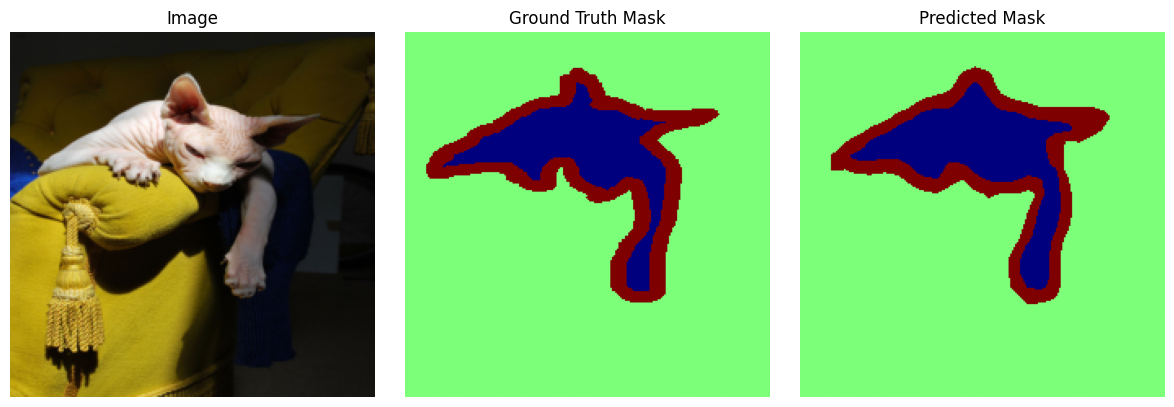

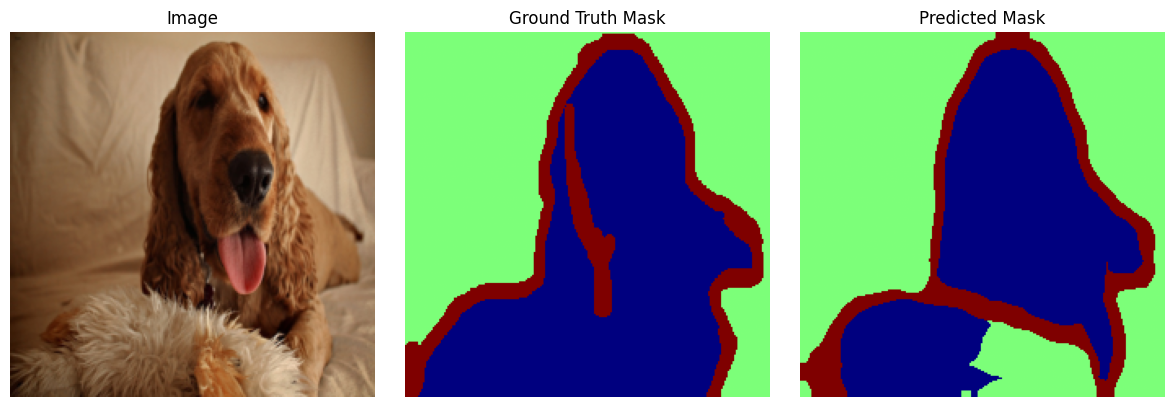

In [11]:
import matplotlib.pyplot as plt
import random

model.eval()
num_show = 2

with torch.no_grad():
    for _ in range(num_show):
        i = random.randint(0, len(val_ds) - 1)
        img, gt_mask = val_ds[i]
        img_ = img.unsqueeze(0).to(device)

        pred = model(img_)["out"]  # shape [1, 3, H, W]
        pred_mask = pred.argmax(dim=1).squeeze(0).cpu().numpy()  # [H, W] in {0,1,2}

        # Convert Tensors to numpy for display
        img_np = img.permute(1, 2, 0).numpy()  # [H,W,C], unnormalized
        gt_mask_np = gt_mask.numpy()

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(img_np)
        axes[0].set_title("Image")
        axes[0].axis('off')

        axes[1].imshow(gt_mask_np, cmap="jet")
        axes[1].set_title("Ground Truth Mask")
        axes[1].axis('off')

        axes[2].imshow(pred_mask, cmap="jet")
        axes[2].set_title("Predicted Mask")
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

Here you’ll see how the model is segmenting (roughly) each pixel into your three classes (0,1,2) for pet, border, and background.

# Summary

  1. Load the Oxford-IIIT Pet dataset in segmentation mode (target_types="segmentation").
  2.	Transform images (Resize, ToTensor) and masks (Resize NEAREST, convert to LongTensor, shift labels to {0,1,2}).
  3.	Use a pretrained model (e.g. fcn_resnet50) and replace the output layer(s) to match your number of segmentation classes.
  4.	Train with CrossEntropyLoss.
  5.	Visualize predicted masks to check performance.

This template can be expanded with better augmentations, hyperparameters, and multi-epoch training. But it shows the essentials for semantic segmentation using Oxford-IIIT Pet within PyTorch/TorchVision. Enjoy experimenting!

# Simple Segmentation Model - Weakly Supervised Learning

---

Below is a conceptual walkthrough and a working skeleton of how you might build a weakly supervised segmentation pipeline on the Oxford-IIIT Pet dataset—using only image-level labels (i.e., breed labels) to produce pseudo segmentation masks. We then train a standard segmentation model on those pseudo masks.

> Disclaimer: True weakly supervised segmentation can get quite advanced. The code below is meant to show the key ideas of a CAM-based pipeline rather than serve as a fully optimized solution. In practice, you’d likely incorporate more sophisticated methods (e.g., multi-scale CAMs, CRF post-processing, region refinement, advanced losses, etc.).







## Overview of the Workflow
  1.	Classification Dataset: Load Oxford-IIIT Pet with classification labels only (target_types="category").
  2.	Train or Load a Pretrained Classification Model (e.g., ResNet) on the Pet dataset to classify each image into one of the 37 breeds.
  3.	Generate Class Activation Maps (CAMs): For each image, run a forward pass, extract the activation map for the predicted breed, and transform it into a 2D heatmap that highlights regions important for the classification.
  4.	Threshold CAMs: Convert each CAM into a binary or multi-label segmentation mask: “pet” vs. “not pet.” (We’ll ignore the breed differences for the segmentation masks. We only care about foreground vs. background.)
  5.	Train a Segmentation Model (e.g., FCN, DeepLab, etc.) on these pseudo masks as if they were ground-truth.
  6.	Refine if needed (CRF or other post-processing).

This method is a typical image-level label approach: the model “learns” to localize the pet using classification alone, then we use the CAM as a surrogate segmentation label.

# 1. Setting Up

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Load the Oxford-IIIT Pet Dataset (Classification Labels)

We only need image–class pairs, so we use:

In [12]:
from torchvision.datasets import OxfordIIITPet

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Optional normalization if you like:
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

dataset = OxfordIIITPet(
    root="./oxford_iiit_data",
    download=True,
    target_types="category",  # classification labels only
    transform=transform,
    # By default or with split="trainval", you'll get ~3680 images
    # If you want the test set too, load separately or specify "test".
)

# For demonstration, just do a small train/val split:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

num_classes = 37  # There are 37 pet breeds

# 3. Train (or Load) a Classification Model

We can use a ResNet pretrained on ImageNet, then fine-tune it on the 37-breed classification task.

In [13]:
import torchvision.models as models

model_cls = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
# Replace the final linear layer for 37-class output:
in_feats = model_cls.fc.in_features
model_cls.fc = nn.Linear(in_feats, num_classes)
model_cls = model_cls.to(device)

criterion_cls = nn.CrossEntropyLoss()
optimizer_cls = optim.Adam(model_cls.parameters(), lr=1e-4)

def train_classification(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)  # shape [B, 37]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / len(loader), 100.0 * correct / total

def eval_classification(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), 100.0 * correct / total

num_epochs = 5  # for demonstration only
for epoch in range(num_epochs):
    train_loss, train_acc = train_classification(model_cls, train_loader, optimizer_cls, criterion_cls, device)
    val_loss, val_acc = eval_classification(model_cls, val_loader, criterion_cls, device)
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.2f}%")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


Epoch [1/5]
  Train Loss: 1.4149, Train Acc: 72.93%
  Val   Loss: 0.4642, Val   Acc: 88.59%
Epoch [2/5]
  Train Loss: 0.2582, Train Acc: 94.97%
  Val   Loss: 0.3775, Val   Acc: 89.54%
Epoch [3/5]
  Train Loss: 0.0929, Train Acc: 98.74%
  Val   Loss: 0.3286, Val   Acc: 89.27%
Epoch [4/5]
  Train Loss: 0.0515, Train Acc: 99.15%
  Val   Loss: 0.3388, Val   Acc: 90.90%
Epoch [5/5]
  Train Loss: 0.0462, Train Acc: 99.15%
  Val   Loss: 0.3428, Val   Acc: 89.81%


Train longer if you want better classification accuracy. You can also do frozen backbone or more advanced fine-tuning.


# 4. Create Class Activation Maps (CAM)

**4.1 Core Idea**

For a convolutional architecture like ResNet, the final layers produce a feature map from which the network makes classification predictions. CAM or Grad-CAM uses the feature maps and weights to highlight the most “discriminative” image regions for a given class.

We’ll do a simple version of CAM (a classical approach from the [“Learning Deep Features for Discriminative Localization” paper](https://arxiv.org/abs/1512.04150)), which requires:
 *	A final convolutional feature map (before avg-pool)
 *	The classification weight associated with each class


> Note: For ResNet50 in TorchVision, the final feature map is typically the output of model.layer4 just before the average pool. We can register a forward hook to capture that.


**4.2 Hook to Capture Feature Maps**

In [14]:
feature_maps = []

def hook_forward(module, input, output):
    # output shape: [B, 2048, H, W] for ResNet50 layer4
    feature_maps.append(output)

# Register hook on layer4
layer4 = model_cls.layer4
hook_handle = layer4.register_forward_hook(hook_forward)

When we do a forward pass, the global variable feature_maps will store the final convolutional feature maps.


**4.3 Generating the CAM**
  1.	Forward pass through model.
  2.	Get the predicted class score and the corresponding weight from model_cls.fc.
  3.	Multiply the weight vector (for that class) with the global feature map channels, then combine (sum) to get a 2D map.
  4.	Upsample to image size.
  5.	Threshold to produce a binary mask (pet vs. background).

We only do this for the top-1 predicted breed—the model’s best guess. (More complex WSS can combine multiple classes or handle multi-label, but here we assume each image has a single breed.)

In [15]:
import torch.nn.functional as F

def get_cam(model, image_tensor, device):
    """
    Generate a CAM for 'image_tensor' (shape [1, C, H, W]) using the top-1 predicted class.
    Returns: a 2D CAM of shape [H, W] in [0..1].
    """
    global feature_maps
    feature_maps = []  # clear before forward

    # Forward pass
    output = model(image_tensor.to(device))   # shape [1, 37]
    pred_class = output.argmax(dim=1).item()

    # Save the final feature map (from the hook)
    # feature_maps[0] shape: [1, 2048, H_feat, W_feat]
    fmap = feature_maps[0]

    # Get the FC layer weights for the predicted class (shape [2048])
    # model_cls.fc.weight: shape [37, 2048], so we want the row for 'pred_class'
    fc_weights = model_cls.fc.weight[pred_class]  # shape [2048]

    # Build the CAM by a weighted sum of the feature map channels
    # fmap: [1, 2048, Hf, Wf], fc_weights: [2048]
    # Multiply each channel in fmap by the corresponding weight in fc_weights
    with torch.no_grad():
        cam = torch.zeros(fmap.shape[2:], dtype=torch.float32, device=device)
        for c in range(fmap.shape[1]):
            cam += fc_weights[c] * fmap[0, c, :, :]

        # ReLU
        cam = F.relu(cam)

        # Normalize CAM to [0..1]
        cam -= cam.min()
        if cam.max() > 0:
            cam /= cam.max()

    return cam.cpu().numpy(), pred_class

This yields a 2D map [H_feat, W_feat] of the “discriminative” region for the predicted class. Next, we upsample to 224×224 (our input size).

In [16]:
import cv2  # for a quick upsampling (or use torch.nn.functional.interpolate)

def upsample_cam(cam_2d, size=(224, 224)):
    """
    cam_2d: np array [H_feat, W_feat]
    size: desired (H, W) for final CAM
    """
    cam_2d_resized = cv2.resize(cam_2d, size, interpolation=cv2.INTER_LINEAR)
    return cam_2d_resized

**4.4 Converting CAM to a Binary Mask**

We want “pet” vs “not pet” (ignoring border for now). We might pick a threshold (e.g. 0.2 or 0.3) to binarize the CAM:

In [17]:
def binarize_cam(cam_2d, threshold=0.2):
    """
    cam_2d in [0..1]
    returns binary mask in {0,1}
    """
    mask = (cam_2d >= threshold).astype(np.uint8)
    return mask

# 5. Generate Pseudo Masks for the Entire Dataset

We’ll create pseudo ground-truth segmentation labels for each image by:
  1.	Doing a forward pass and extracting the CAM.
  2.	Upsampling.
  3.	Thresholding.
  4.	Saving the result or storing in memory.

> This may take time for large datasets. Often you might store these masks on disk, so you can reload them quickly without recalculating CAM each time.

In [18]:
def generate_pseudo_masks(model, dataset, device, cam_threshold=0.2):
    """
    model: classification model
    dataset: classification dataset (image, label)
    Return:
      A list of (image_tensor, pseudo_mask) pairs
        - image_tensor: shape [C, H, W]
        - pseudo_mask: shape [H, W] in {0,1}
    """
    pseudo_data = []
    model.eval()

    for i in range(len(dataset)):
        image_tensor, _ = dataset[i]  # ignore classification label
        image_tensor = image_tensor.unsqueeze(0).to(device)  # shape [1,C,H,W]

        with torch.no_grad():
            cam_2d, _ = get_cam(model, image_tensor, device)
            cam_2d_resized = upsample_cam(cam_2d, size=(224,224))
            mask_np = binarize_cam(cam_2d_resized, threshold=cam_threshold)

        # Convert mask to a torch tensor
        mask_tensor = torch.from_numpy(mask_np).long()  # shape [H,W], in {0,1}

        pseudo_data.append( (dataset[i][0], mask_tensor) )  # (image, mask)

    return pseudo_data

# Example on the training set:
pseudo_train_data = generate_pseudo_masks(model_cls, train_ds, device, cam_threshold=0.2)
pseudo_val_data   = generate_pseudo_masks(model_cls, val_ds,   device, cam_threshold=0.2)

print("Pseudo-labeled data (train):", len(pseudo_train_data))
print("Pseudo-labeled data (val)  :", len(pseudo_val_data))

Pseudo-labeled data (train): 2944
Pseudo-labeled data (val)  : 736


Now, pseudo_train_data[i] is (image_tensor, mask_tensor), where mask_tensor is our weakly supervised guess for the segmentation label.


# 6. Train a Segmentation Model on the Pseudo Masks

We can wrap these pairs in a custom Dataset so we can feed them to a DataLoader.

In [19]:
class PseudoSegDataset(torch.utils.data.Dataset):
    def __init__(self, data_list):
        # data_list: list of (image_tensor, mask_tensor)
        self.data_list = data_list

    def __getitem__(self, idx):
        return self.data_list[idx]  # (image, mask)

    def __len__(self):
        return len(self.data_list)

train_seg_ds = PseudoSegDataset(pseudo_train_data)
val_seg_ds   = PseudoSegDataset(pseudo_val_data)

train_seg_loader = DataLoader(train_seg_ds, batch_size=32, shuffle=True, num_workers=2)
val_seg_loader   = DataLoader(val_seg_ds, batch_size=32, shuffle=False, num_workers=2)

**6.1 Build a Pretrained Segmentation Model**

We’ll do something simple like FCN-ResNet50. But now, we only have 2 classes: “pet” vs. “background.” So we need the final layer to have out_channels=2.

In [20]:
import torchvision.models.segmentation as segm_models

model_seg = segm_models.fcn_resnet50(weights=segm_models.FCN_ResNet50_Weights.DEFAULT)
# The final classifier: model_seg.classifier[4] is nn.Conv2d(512, 21, 1)
# We want out_channels=2:
model_seg.classifier[4] = nn.Conv2d(512, 2, kernel_size=1)
model_seg.aux_classifier[4] = nn.Conv2d(256, 2, kernel_size=1)

model_seg = model_seg.to(device)

criterion_seg = nn.CrossEntropyLoss()
optimizer_seg = optim.Adam(model_seg.parameters(), lr=1e-4)

**6.2 Training Loop for Segmentation**

Remember: the output dictionary from FCN is typically {"out": main_prediction, "aux": aux_prediction}. We can combine them or just use out for the main loss:

In [22]:
def train_segmentation(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for images, masks in loader:
        images = images.to(device)         # [B,C,H,W]
        masks = masks.to(device)          # [B,H,W], each pixel in {0,1}

        optimizer.zero_grad()
        outputs = model(images)           # dict with 'out' and 'aux'
        logits = outputs["out"]           # [B,2,H,W]

        loss_main = criterion(logits, masks)

        # Optionally handle aux loss
        # aux_logits = outputs["aux"]      # [B,2,H,W]
        # loss_aux = criterion(aux_logits, masks)
        # loss = loss_main + 0.4 * loss_aux
        loss = loss_main

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    return running_loss / len(loader)

def eval_segmentation(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            logits = outputs["out"]
            loss = criterion(logits, masks)
            running_loss += loss.item()
    return running_loss / len(loader)

num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train_segmentation(model_seg, train_seg_loader, optimizer_seg, criterion_seg, device)
    val_loss   = eval_segmentation(model_seg, val_seg_loader, criterion_seg, device)
    print(f"Epoch [{epoch+1}/{num_epochs}]  Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch [1/5]  Train Loss: 0.2360, Val Loss: 0.2724
Epoch [2/5]  Train Loss: 0.1688, Val Loss: 0.2803
Epoch [3/5]  Train Loss: 0.1301, Val Loss: 0.3116
Epoch [4/5]  Train Loss: 0.1072, Val Loss: 0.3479
Epoch [5/5]  Train Loss: 0.0905, Val Loss: 0.3382


Again, 5 epochs is a toy demonstration. You’d usually train longer.

# 7. Visualize Results

Finally, we can do a quick check on some images from val_seg_loader to see how well the model is segmenting.

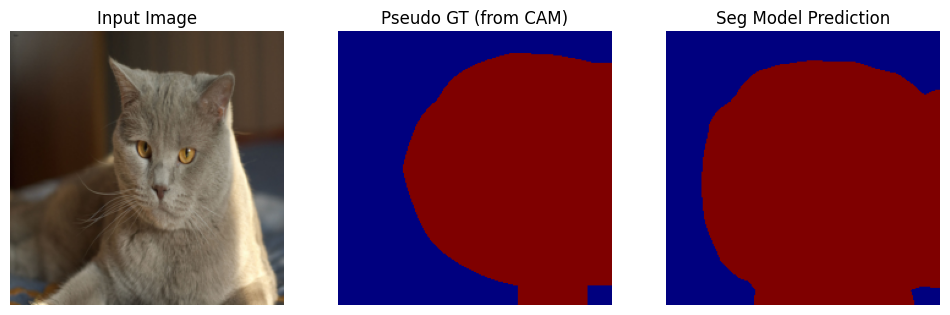

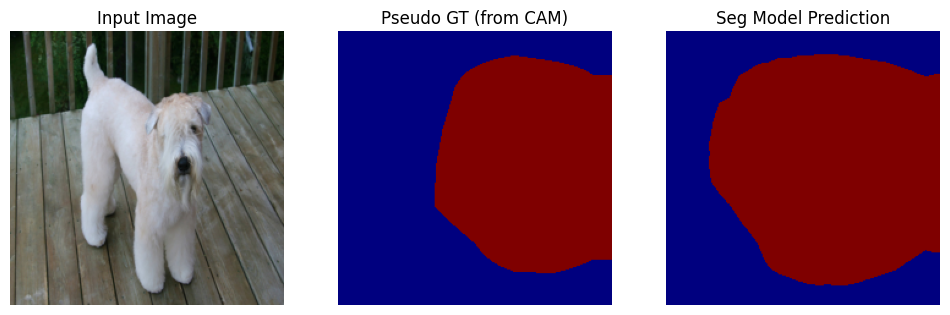

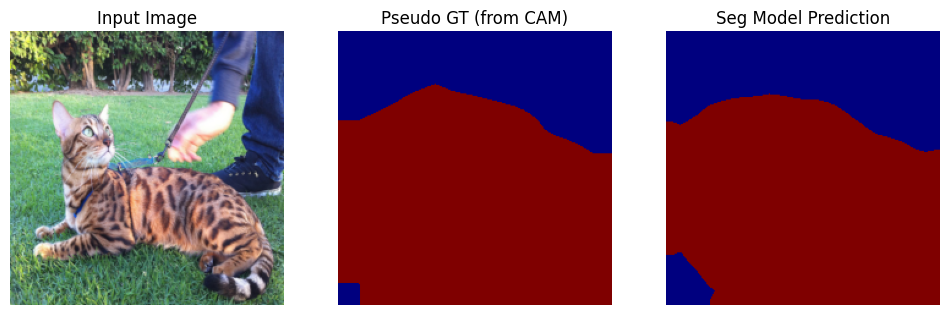

In [23]:
import random
import matplotlib.pyplot as plt

model_seg.eval()
num_show = 3
with torch.no_grad():
    for _ in range(num_show):
        i = random.randint(0, len(val_seg_ds) - 1)
        image, pseudo_label = val_seg_ds[i]  # shape [C,H,W], [H,W]
        inp = image.unsqueeze(0).to(device)

        out_dict = model_seg(inp)
        pred = out_dict["out"]  # [1, 2, H, W]
        pred_mask = torch.argmax(pred, dim=1).squeeze(0).cpu().numpy()  # [H, W] in {0,1}

        fig, axes = plt.subplots(1, 3, figsize=(12,4))
        # Convert image to numpy
        img_np = image.permute(1,2,0).numpy()

        axes[0].imshow(img_np)
        axes[0].set_title("Input Image")
        axes[0].axis("off")

        axes[1].imshow(pseudo_label.cpu().numpy(), cmap="jet")
        axes[1].set_title("Pseudo GT (from CAM)")
        axes[1].axis("off")

        axes[2].imshow(pred_mask, cmap="jet")
        axes[2].set_title("Seg Model Prediction")
        axes[2].axis("off")

        plt.show()

You’ll see how the classification-based pseudo labels differ from the model’s final predicted segmentation. Depending on your threshold, some masks might be small or highlight only the pet’s “most discriminative” region. That’s a common limitation of naive CAM-based weak supervision.


## Enhancements & Best Practices
  1.	Refinement:
    *	Vanilla CAM often covers only the object’s most salient parts. Approaches like Grad-CAM++, LayerCAM, and IRNet can yield better coverage.
    *	Post-processing with CRFs or morphological operations can improve the pseudo masks before training your segmentation model.
  2.	Multiple Thresholds / Multi-Scale:
    *	You can generate multiple CAM scales or multiple thresholds and combine them, giving your segmentation model more robust pseudo annotations.
  3.	Ignore Regions:
    *	Some methods treat uncertain regions (low activation) as “ignore labels” during training so you do not penalize the model for uncertain pixels.
  4.	Class-Agnostic vs. Class-Specific:
    *	Here, we collapsed 37 breeds into a single “foreground = pet.” You could do a more advanced approach that tries to segment each breed distinctly. But that demands more sophisticated class-specific CAM usage.
  5.	Better Data:
    *	If you have any bounding box or partial label, you can incorporate it for better weak supervision.


---


## Conclusion

This example demonstrates one classic approach for weakly supervised segmentation:
  1.	Classification model →
  2.	CAM generation →
  3.	Pseudo-labeled masks →
  4.	Train a standard segmentation model on these pseudo labels.

While the results may be limited compared to fully supervised training (where you have ground-truth pixel masks), this pipeline can localize objects fairly well using only image-level labels. For real-world usage, consider more advanced CAM variants or extra refinement steps to get higher-quality pseudo segmentation masks.

## Some Q&A

1. Difference between supervised and weakly supervised.
2. Why do we only use these special techniques, such as CAM, etc., in weakly supervised?
3. Why use a classification model and a segmentation model in weakly supervised segmentation?

> Below is a conceptual explanation addressing your three questions about supervised versus weakly supervised approaches for segmentation, why special methods like CAM are used in the weakly supervised setting, and why it often involves both a classification and a segmentation model.

### 1. Difference Between Supervised and Weakly Supervised Segmentation

**Supervised Segmentation**
  *	Annotation Type: Full pixel-level labels (a ground truth segmentation mask) for each image.
  *	Training Setup: The model directly compares its pixel-level predictions to the pixel-level ground truth.
  *	Example: A fully supervised pipeline for semantic segmentation on Oxford-IIIT Pet would have a perfect trimap (or multi-class mask) for each image telling exactly which pixels belong to the pet, the border, background, etc.

**Weakly Supervised Segmentation**
  *	Annotation Type: Partial or incomplete labels. Examples include:
    *	Image-level labels (e.g., just the breed label: “Abyssinian cat”)
	  *	Bounding boxes but no pixel-level masks
    *	Scribbles or points indicating some pixels but not the entire object shape
    * etc.
  *	Training Setup: The segmentation model does not have a direct pixel-level label for every pixel. Instead, it must infer the object’s shape using higher-level or partial annotations.
  *	Goal: Produce a segmentation mask at inference time, despite only having weaker forms of supervision during training.

In short:
  *	Fully supervised: you have exact labels for each pixel → direct, more accurate training signal.
  *	Weakly supervised: you only have partial or higher-level labels → you must use special methods to approximate or guess pixel-level labels.

### 2. Why Do We Use Special Techniques (e.g., CAM) in Weakly Supervised?

Because weak supervision does not provide ground truth masks, we can’t do a straightforward pixel-by-pixel comparison. Instead, we rely on indirect cues:

*	Class Activation Maps (CAM), Grad-CAM, etc.:
	*	Exploit the internal representations of a classification network trained only on image-level labels.
	*	Identify which image regions are most “discriminative” for that class (e.g., which pixels strongly influence the “Abyssinian cat” vs. “Border Collie” classification).
	*	These discriminative regions serve as a pseudo or approximate segmentation mask.
*	Other Weakly Supervised Tricks:
  * Multiple Instance Learning (MIL), attention maps, region proposals combined with global labels, CRF or other shape constraints, etc.

We use these techniques because without pixel-level labels, the model needs an algorithmic way to figure out which pixels are relevant for the object. CAM-based methods are a common approach for image-level labels:

  1.	Train a classifier that recognizes “What breed is in this image?”
  2.	Use CAM to highlight “Where in the image does the model see breed-specific features?”
  3.	Convert that highlight into a “pseudo mask.”

In other words, we repurpose a purely classification model’s internal activations as if they were segmentation cues.

### 3. Why Use a Classification Model and a Segmentation Model in Weakly Supervised Segmentation?

Often, weakly supervised segmentation is done in two main phases:
1.	Classification Phase:
  *	You have image-level labels (which class or classes appear in the image).
  *	You train a classification network (e.g., ResNet) to predict those labels.
  *	This step is straightforward because classification just needs an image→label mapping.

2.	Pseudo-Mask Generation (CAM, Grad-CAM, etc.):
  * Once trained, the classification model “knows” the discriminative features for each class.
  *	You apply CAM or a related method to each image to obtain a pseudo segmentation mask that localizes the class.

3.	Segmentation Model Phase:

  * Now you have an approximate pixel-level mask (obtained from CAM) even though you never had ground-truth masks.
  *	You can train a standard segmentation model (e.g., FCN, DeepLab, U-Net) using these pseudo masks as if they were labels.
  *	The segmentation network may refine or learn a more holistic shape representation than the classification net alone.

**Why not just stop at the classification network’s CAM?**
* A typical classification network’s CAM might only highlight the most discriminative part of the object (e.g., the face or certain fur patterns). That alone can be incomplete as a segmentation mask. By training a segmentation model (step 3) on many such pseudo masks, you can learn a more robust pixel-level representation that can fill in the entire object, especially if you apply refinements (CRF, data augmentations, multi-thresholding, etc.).

Hence:
  *	Classification gives you a coarse map (CAM).
  *	Segmentation uses that coarse map to learn a pixel-wise prediction network, which can better reconstruct the entire object shape.



---
In Summary
  1.	Fully supervised vs. weakly supervised differs by the level of annotation (pixel-perfect labels vs. partial/global labels).
  2.	Special techniques (CAM, Grad-CAM, etc.) are needed in the weakly supervised setting because we have no direct pixel-level ground truth. CAMs help us convert image-level labels into approximate object-localization signals.
  3.	Two-stage approach (classification then segmentation) is common in weakly supervised segmentation because we first need a way to discover “where the object is” (via classification’s CAM). Only then can we train a dedicated segmentation model on those pseudo-labeled masks.
